## Using Kerchunk

In this notebook, we'll use a Kerchunk index file to speed up the *metadata reading* for a large collection of NetCDF files. The actual data will still be in the original NetCDF files.

## Kerchunk Background

In the last notebook, we saw that accessing data from the NetCDF file over the network was slow, in part because it was making a bunch of HTTP requests just to read some metadata that's scattered around the NetCDF file. With a Kerchunk index file, you get to bypass all that seeking around for metadata: it's already been extracted into the index file. While that's maybe not a huge deal for a *single* NetCDF file, it matters a bunch when you're dealing with thousands of NetCDF files (2 seconds per file * 1,000 files = ~1 hours *just to read metadata*).

In [1]:
import adlfs
import xarray as xr
import fsspec

# force xarray to import everything
xr.tutorial.open_dataset("air_temperature");

In [18]:
%%time
m = fsspec.get_mapper(
    "reference://",
    fo="abfs://ciroh/short-range-channel_rt-kerchunk/reference.json",
    remote_options={"account_name": "noaanwm"},
    target_options={"account_name": "noaanwm"},
    skip_instance_cache=True,
)

channel_rt = xr.open_dataset(m, engine="zarr", consolidated=False, chunks={"time": 1})
channel_rt

CPU times: user 305 ms, sys: 16.6 ms, total: 321 ms
Wall time: 379 ms


<xarray.Dataset>
Dimensions:         (time: 6866, feature_id: 2776738, reference_time: 1)
Coordinates:
  * feature_id      (feature_id) float64 101.0 179.0 181.0 ... 1.18e+09 1.18e+09
  * reference_time  (reference_time) datetime64[ns] 2022-06-29
  * time            (time) datetime64[ns] 2022-06-29T01:00:00 ... 2023-04-21T...
Data variables:
    crs             (time) object dask.array<chunksize=(1,), meta=np.ndarray>
    nudge           (time, feature_id) float64 dask.array<chunksize=(1, 2776738), meta=np.ndarray>
    qBtmVertRunoff  (time, feature_id) float64 dask.array<chunksize=(1, 2776738), meta=np.ndarray>
    qBucket         (time, feature_id) float64 dask.array<chunksize=(1, 2776738), meta=np.ndarray>
    qSfcLatRunoff   (time, feature_id) float64 dask.array<chunksize=(1, 2776738), meta=np.ndarray>
    streamflow      (time, feature_id) float64 dask.array<chunksize=(1, 2776738), meta=np.ndarray>
    velocity        (time, feature_id) float64 dask.array<chunksize=(1, 2776738), meta=np.ndarray>
Attributes: (12/19)
    Conventions:                CF-1.6
    NWM_version_number:         v2.2
    TITLE:                      OUTPUT FROM NWM v2.2
    cdm_datatype:               Station
    code_version:               v5.2.0-beta2
    dev:                        dev_ prefix indicates development/internal me...
    ...                         ...
    model_output_type:          channel_rt
    model_output_valid_time:    2022-06-29_01:00:00
    model_total_valid_times:    18
    proj4:                      +proj=lcc +units=m +a=6370000.0 +b=6370000.0 ...
    station_dimension:          feature_id
    stream_order_output:        1

You'll notice we're using the `zarr` engine for xarray. That's just a convenient way to expose Kerchunk indexed data to anything that can read Zarr (like xarray), without having to write a dedicated "kerchunk" reader. This actually exposes a bit about how Kerchunk works. Our "mapper", `m` has all of the metadata already in-memory.

Zarr uses a simple dictionary-like interface with well-known keys. You can get the global attributes at `.zattrs`.

In [3]:
import json

json.loads(m[".zattrs"])

{'Conventions': 'CF-1.6',
 'NWM_version_number': 'v2.2',
 'TITLE': 'OUTPUT FROM NWM v2.2',
 'cdm_datatype': 'Station',
 'code_version': 'v5.2.0-beta2',
 'dev': 'dev_ prefix indicates development/internal meta data',
 'dev_NOAH_TIMESTEP': 3600,
 'dev_OVRTSWCRT': 1,
 'dev_channelBucket_only': 0,
 'dev_channel_only': 0,
 'featureType': 'timeSeries',
 'model_configuration': 'short_range',
 'model_initialization_time': '2022-06-29_00:00:00',
 'model_output_type': 'channel_rt',
 'model_output_valid_time': '2022-06-29_01:00:00',
 'model_total_valid_times': 18,
 'proj4': '+proj=lcc +units=m +a=6370000.0 +b=6370000.0 +lat_1=30.0 +lat_2=60.0 +lat_0=40.0 +lon_0=-97.0 +x_0=0 +y_0=0 +k_0=1.0 +nadgrids=@',
 'station_dimension': 'feature_id',
 'stream_order_output': 1}

Or the attributes for a specific array:

In [4]:
json.loads(m["streamflow/.zattrs"])

{'_ARRAY_DIMENSIONS': ['time', 'feature_id'],
 'add_offset': 0.0,
 'coordinates': 'latitude longitude',
 'grid_mapping': 'crs',
 'long_name': 'River Flow',
 'missing_value': -999900,
 'scale_factor': 0.009999999776482582,
 'units': 'm3 s-1',
 'valid_range': [0, 5000000]}

Those attributes saved in the Kerchunk index file, and so don't require any (additional) HTTP requests to get. But we *don't* want to re-save the large data variables, since we don't want to host the data twice. So what happens when you want to read a data variable? Well, we can look at the `references` attribute backing this mapping to find out.

In [5]:
m.fs.references["streamflow/0.0"]

['abfs://nwm/nwm.20220629/short_range/nwm.t00z.short_range.channel_rt.f001.conus.nc',
 614098,
 1860920]

In a typical Zarr dataset, accessing an array at `<name>/0.0` would give you the actual bytes for the data at that location. But recall that with Kerchunk the original data is buried in some NetCDF file. Kerchunk has extracted three pieces of information:

1. The URL where this chunk of data comes from
2. The *offset* within that file
3. The *size* of the chunk of data, in bytes, on disk

Thanks to HTTP range requests (the same thing that powers streaming video) we can request just the subset of the file we need. When a high-level library like xarray asks the data in that chunk, this toolchain (of zarr, fsspec, and adlfs) will make the HTTP range request in the background and deliver the bytes.

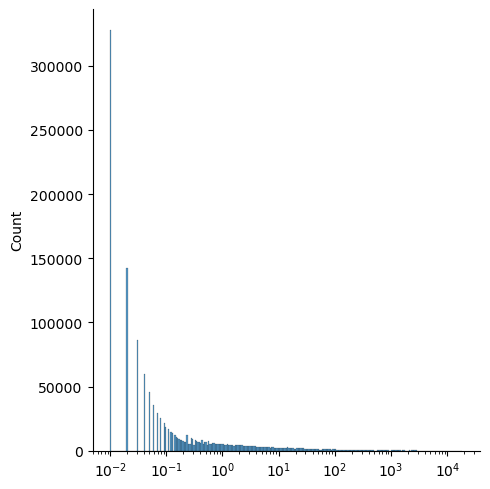

In [6]:
import seaborn as sns

chunk = channel_rt.streamflow.isel(time=0).compute()
sns.displot(chunk[chunk > 0], log_scale=True);

One very important caveat: because Kerchunk is just an index on the existing data, we inherit all of the limitations of its chunking structure. This datsaet is chunked by hour along `time`. We'll return to this later.

I've also created Kerchunk indexes for `land` and `forcing`:

In [7]:
%%time
import requests

fo = requests.get(
    "https://noaanwm.blob.core.windows.net/ciroh/short-range-land-kerchunk/reference.json"
).json()
m = fsspec.get_mapper(
    "reference://",
    fo=fo,
    remote_options={"account_name": "noaanwm"},
    target_options={"account_name": "noaanwm"},
)

land = xr.open_dataset(m, engine="zarr", consolidated=False, chunks={"time": 1})
land

CPU times: user 5.87 s, sys: 642 ms, total: 6.51 s
Wall time: 7.13 s


<xarray.Dataset>
Dimensions:         (time: 6992, y: 3840, x: 4608, reference_time: 1)
Coordinates:
  * reference_time  (reference_time) datetime64[ns] 2022-06-29
  * time            (time) datetime64[ns] 2022-06-29T01:00:00 ... 2023-04-26T...
  * x               (x) float64 -2.303e+06 -2.302e+06 ... 2.303e+06 2.304e+06
  * y               (y) float64 -1.92e+06 -1.919e+06 ... 1.918e+06 1.919e+06
Data variables:
    ACCET           (time, y, x) float64 dask.array<chunksize=(1, 768, 922), meta=np.ndarray>
    FSNO            (time, y, x) float64 dask.array<chunksize=(1, 768, 922), meta=np.ndarray>
    SNEQV           (time, y, x) float64 dask.array<chunksize=(1, 768, 922), meta=np.ndarray>
    SNOWH           (time, y, x) float64 dask.array<chunksize=(1, 768, 922), meta=np.ndarray>
    SNOWT_AVG       (time, y, x) float64 dask.array<chunksize=(1, 768, 922), meta=np.ndarray>
    SOILSAT_TOP     (time, y, x) float64 dask.array<chunksize=(1, 768, 922), meta=np.ndarray>
    crs             (time) object dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    Conventions:                CF-1.6
    GDAL_DataType:              Generic
    NWM_version_number:         v2.2
    TITLE:                      OUTPUT FROM NWM v2.2
    code_version:               v5.2.0-beta2
    model_configuration:        short_range
    model_initialization_time:  2022-06-29_00:00:00
    model_output_type:          land
    model_output_valid_time:    2022-06-29_01:00:00
    model_total_valid_times:    18
    proj4:                      +proj=lcc +units=m +a=6370000.0 +b=6370000.0 ...

In [59]:
%%time
import requests

fo = requests.get(
    "https://noaanwm.blob.core.windows.net/ciroh/short-range-forcing-kerchunk/reference.json"
).json()
m = fsspec.get_mapper(
    "reference://",
    fo=fo,
    remote_options={"account_name": "noaanwm"},
    target_options={"account_name": "noaanwm"},
)

forcing = xr.open_dataset(m, engine="zarr", consolidated=False, chunks={"time": 1})
forcing

CPU times: user 4.92 s, sys: 925 ms, total: 5.84 s
Wall time: 6.56 s


<xarray.Dataset>
Dimensions:         (time: 7306, y: 3840, x: 4608, reference_time: 1)
Coordinates:
  * reference_time  (reference_time) datetime64[ns] 2022-06-29
  * time            (time) datetime64[ns] 2022-06-29T01:00:00 ... 2023-04-29T...
  * x               (x) float64 -2.303e+06 -2.302e+06 ... 2.303e+06 2.304e+06
  * y               (y) float64 -1.92e+06 -1.919e+06 ... 1.918e+06 1.919e+06
Data variables:
    LWDOWN          (time, y, x) float64 dask.array<chunksize=(1, 768, 922), meta=np.ndarray>
    PSFC            (time, y, x) float64 dask.array<chunksize=(1, 768, 922), meta=np.ndarray>
    Q2D             (time, y, x) float64 dask.array<chunksize=(1, 768, 922), meta=np.ndarray>
    RAINRATE        (time, y, x) float32 dask.array<chunksize=(1, 768, 922), meta=np.ndarray>
    SWDOWN          (time, y, x) float64 dask.array<chunksize=(1, 768, 922), meta=np.ndarray>
    T2D             (time, y, x) float64 dask.array<chunksize=(1, 768, 922), meta=np.ndarray>
    U2D             (time, y, x) float64 dask.array<chunksize=(1, 768, 922), meta=np.ndarray>
    V2D             (time, y, x) float64 dask.array<chunksize=(1, 768, 922), meta=np.ndarray>
    crs             object ...
Attributes:
    NWM_version_number:         v2.2
    model_configuration:        short_range
    model_initialization_time:  2022-06-29_00:00:00
    model_output_type:          forcing
    model_output_valid_time:    2022-06-29_01:00:00
    model_total_valid_times:    18

Play around with these for a bit.

In [62]:
import odc.geo
import rioxarray

In [63]:
forcing.rio.crs

In [64]:
import pyproj

crs = pyproj.CRS.from_cf(forcing.crs.attrs)
forcing = forcing.rio.write_crs(crs)
forcing

<xarray.Dataset>
Dimensions:         (time: 7306, y: 3840, x: 4608, reference_time: 1)
Coordinates:
    crs             int64 0
  * reference_time  (reference_time) datetime64[ns] 2022-06-29
  * time            (time) datetime64[ns] 2022-06-29T01:00:00 ... 2023-04-29T...
  * x               (x) float64 -2.303e+06 -2.302e+06 ... 2.303e+06 2.304e+06
  * y               (y) float64 -1.92e+06 -1.919e+06 ... 1.918e+06 1.919e+06
Data variables:
    LWDOWN          (time, y, x) float64 dask.array<chunksize=(1, 768, 922), meta=np.ndarray>
    PSFC            (time, y, x) float64 dask.array<chunksize=(1, 768, 922), meta=np.ndarray>
    Q2D             (time, y, x) float64 dask.array<chunksize=(1, 768, 922), meta=np.ndarray>
    RAINRATE        (time, y, x) float32 dask.array<chunksize=(1, 768, 922), meta=np.ndarray>
    SWDOWN          (time, y, x) float64 dask.array<chunksize=(1, 768, 922), meta=np.ndarray>
    T2D             (time, y, x) float64 dask.array<chunksize=(1, 768, 922), meta=np.ndarray>
    U2D             (time, y, x) float64 dask.array<chunksize=(1, 768, 922), meta=np.ndarray>
    V2D             (time, y, x) float64 dask.array<chunksize=(1, 768, 922), meta=np.ndarray>
Attributes:
    NWM_version_number:         v2.2
    model_configuration:        short_range
    model_initialization_time:  2022-06-29_00:00:00
    model_output_type:          forcing
    model_output_valid_time:    2022-06-29_01:00:00
    model_total_valid_times:    18

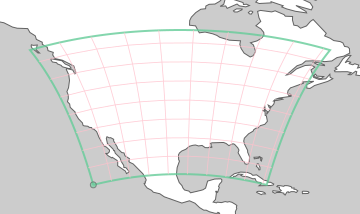

In [66]:
forcing.odc.geobox

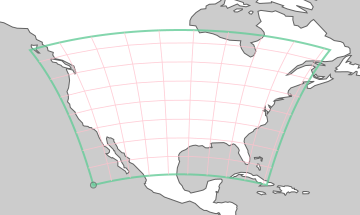

In [83]:
x = (
    forcing.isel(time=0)
    .T2D.coarsen({"x": 10, "y": 10}, boundary="trim")
    .mean()
    .compute()
)
x.odc.geobox

In [85]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

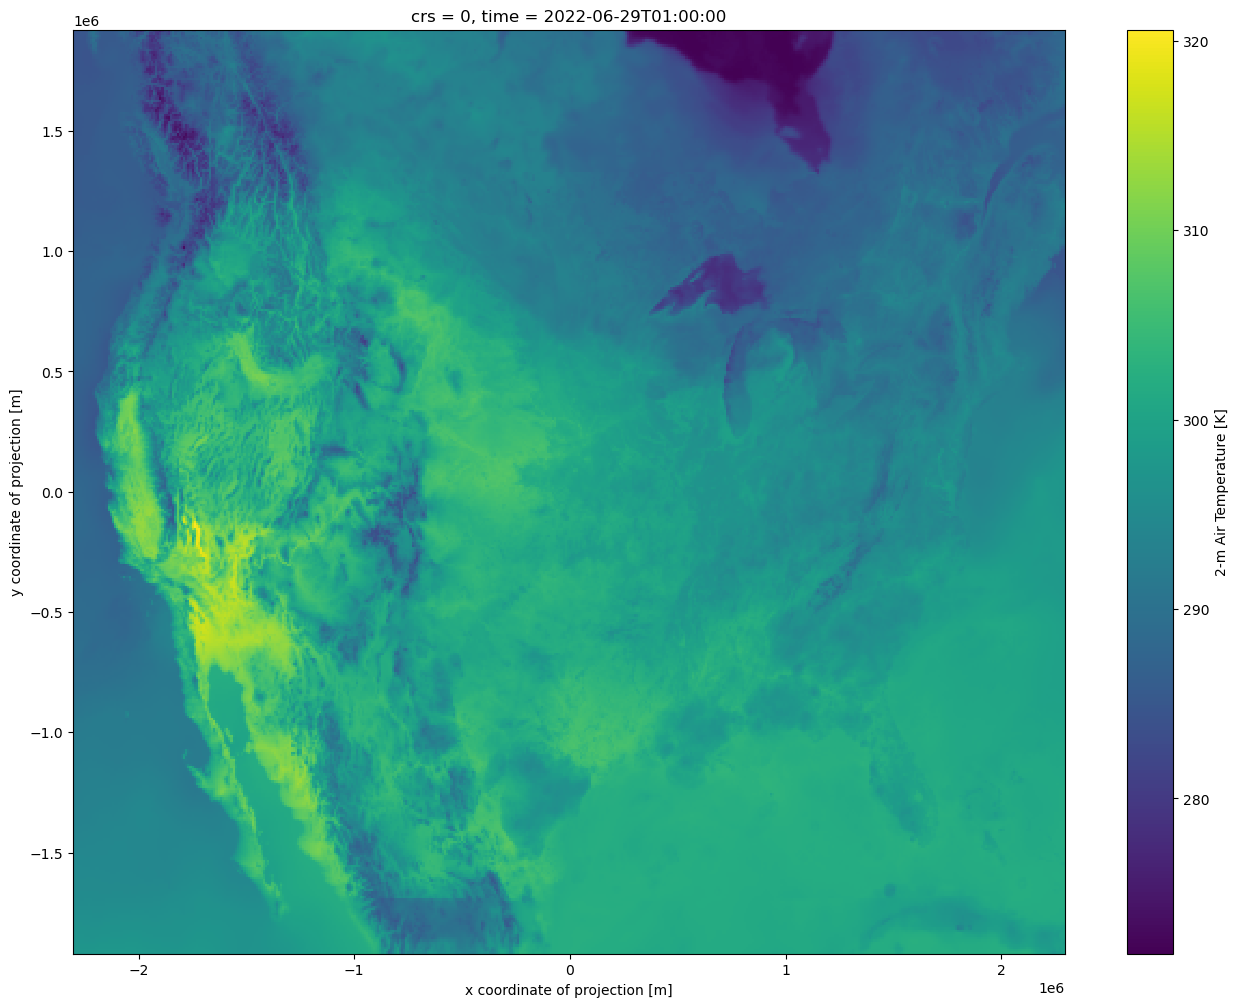

In [89]:
x.plot(size=12);